In [15]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
#import obspy
import glob
import random
from __future__ import division
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
def get_data(data):
    '''
    get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = np.array(data['data']['x'])
    y = np.array(data['data']['y'])
    z = np.array(data['data']['z'])

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = np.linspace(t0, t1, npoints)
    
    #trigger time
    try:
        triggerTime = data['header']['triggertime']
        startTime   = data['header']['starttime']
        duration = int((triggerTime - startTime) * sampling_rate)
    except:
        duration = 0
    
    # station latitude and long
    return t, x, y, z, duration

In [17]:
def plot_data(t, x, y, z):
    '''
    helper function to plot the 3-component acceleration data
    '''
    plt.figure()
    plt.subplot(311)
    plt.plot(t, x)
    plt.subplot(312)
    plt.plot(t, y)
    plt.ylabel('Acceleration (g)')
    plt.subplot(313)
    plt.plot(t, z)
    plt.xlabel('Time (sec)')
    plt.show()
    # spectrogram
    plt.figure()
    rate = 25
    timeWindow = 2
    plt.subplot(311)
    specgram(x, NFFT=rate * timeWindow, Fs=rate, noverlap = 5);
    plt.subplot(312)
    specgram(y, NFFT=rate * timeWindow, Fs=rate, noverlap = 5);
    plt.subplot(313)
    specgram(z, NFFT=rate * timeWindow, Fs=rate, noverlap = 5);
    plt.show()
    

True
../../data/EQ/shake_table/trial20_phone0.json
5.64611050921


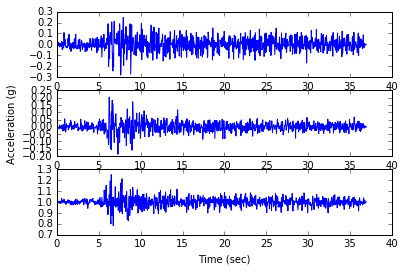

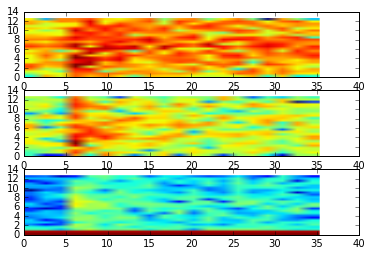

In [18]:
import os
import random
def Sampling(label = None, sim = False):
    '''
    Draw a sample from data
    
    Args:
    label: boolean, the label of the sample, 1 if shaketable, 0 if human
    
    Returns:
    t     : 1d array, time.
    x     : 1d array, x.
    y     : 1d array, y orthogonal to x.
    z     : 1d array, z (vertical).
    label : boolean.
    '''
    rng = random.Random()
    if label is None:
        label = (rng.random() > 0.5)
    if label:
        path = '../../data/EQ/shake_table/'
    else:
        path = '../../data/Human/'
    if sim:
        path = '../../data/EQ/simulated/'
    files = os.listdir(path)
    oneFile = path + rng.sample(files, 1)[0]
    data = json.load(open(oneFile, 'r'))
    t, x, y, z, duration = get_data(data)
    if label:
        duration = NaiveTrigger(x, y, z)
        
    return(t, x, y, z, label, oneFile, duration)
t, x, y, z, label, filename, duration = Sampling(True)
print(label)
print(filename)
print(t[duration])
#tmp = range(duration - 50, duration + 50)
tmp = range(len(x))
plot_data(t[tmp], x[tmp], y[tmp], z[tmp])
#out = obspy.signal.trigger.classic_sta_lta_py(z, 150, 12)
#plt.plot(out)

In [19]:
def NaiveTrigger(x, y, z):
    '''
    Naive trigger
    '''
    std_x = np.std(x[0:100])
    std_y = np.std(y[0:100])
    std_z = np.std(z[0:100])
    mean_x = np.mean(x[0:100])
    mean_y = np.mean(y[0:100])
    mean_z = np.mean(z[0:100])
    thres = 6
    for i in range(len(x)):
        if abs(x[i] - mean_x) > 6 * std_x:
            return(i)
        if abs(y[i] - mean_y) > 6 * std_y:
            return(i)
        if abs(z[i] - mean_z) > 6 * std_z:
            return(i)
    raise Exception('Should not be here')

In [20]:
def normalize(x):
    if np.std(x) > 1e-10:
        return((x - median(x))/np.std(x))
    else:
        return(x - median(x))

In [21]:
# Generate an aggregate dataset with only the data around trigger time
def Aggregate(m = 1000, n = 10000, window = 25):
    '''
    Aggregate the data between triggerTime+/- window
    '''
    data = np.zeros((m + n, window * 2 * 3 + 1))
    for line in range(m):
        t, x, y, z, label, filename, duration = Sampling(True)
        if duration > window and duration + window < len(t):
            tmp = range(duration - window, duration + window)
            data[line, :] = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp]), [1]))
        else:
            print('Import Exception 1.')
    for line in range(m, m + n):
        t, x, y, z, label, filename, duration = Sampling(False)
        if duration > window and duration + window < len(t):
            tmp = range(duration - window, duration + window)
            data[line, :] = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp]), [0]))
        else:
            tmp = range(0, 2 * window)
            data[line, :] = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp]), [0]))
            #print('Import Exception 2')
            #print(line)
            #print(data[line,:])
            #assert(1 == 0)
    return(data)
data = Aggregate(n = 10000)
#data = data1[:2000,:]
#testdata = data1
testdata = Aggregate()
#print(testdata[1:10,:])
#print(len(np.where(abs(testdata[:,10]) < 1e-4)[0]))

In [ ]:
import pickle
#f = open('store.pckl', 'wb')
#pickle.dump(svc, f)
#f.close()

f = open('store.pckl', 'rb')
svc = pickle.load(f)
f.close()

In [22]:
def Eval(label1, trueLabel):
    truePos = sum((label1 == 1) * (trueLabel == 1))
    trueNeg = sum((label1 == 0) * (trueLabel == 0))
    falsePos = sum((label1 == 1) * (trueLabel == 0))
    falseNeg = sum((label1 == 0) * (trueLabel == 1))
    #print truePos, trueNeg, falsePos, falseNeg
    type1 = 1. * falsePos / (falsePos + truePos)
    type2 = 1. * falseNeg / (falseNeg + trueNeg)
    return(type1, type2)

In [23]:
# sklearn
from sklearn.svm import SVC
#svc = SVC(kernel='poly', degree=4, coef0=0)
svc = SVC(kernel='poly', degree=2, coef0=0, C=10)
#svc = SVC(kernel='linear', degree=2, coef0=0, C=10)

svc.fit(data[:,:150], data[:,150])
#print(svc.n_support_)
#svc.score(data[:,:150], data[:,150])
#weight = svc.coef_
#plt.plot(weight[0,:])
#plt.figure()
label1 = svc.predict(data[:,:150])
label2 = svc.predict(testdata[:,:150])
trueLabel = data[:,150]
#plt.scatter(range(len(label2)), label2 == testdata[:, 150])
print(np.where(label2 != testdata[:, 150]))
#print(Eval(label1, trueLabel))
print(Eval(label2, testdata[:, 150]))


(array([  12,  331,  468, 1728, 3727, 3772, 4793, 8983, 9859]),)
(0.0059820538384845467, 0.00030009002700810244)


In [76]:
n = len(glob.glob('../../minidata/shake_table/*'))
print(n)
features = np.zeros((192,1))
window = 25

for (i,f) in enumerate(glob.glob('../../minidata/shake_table/*')):
    dd = json.load(open(f, 'rb'))
    t, x, y, z, duration = get_data(dd)
    duration = NaiveTrigger(x, y, z)
    if duration > window and duration + window < len(t):
        tmp = range(duration - window, duration + window)
        tmp1 = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp])))
    features[i,0] = svc.predict(tmp1.reshape(1, -1))

n = len(glob.glob('../../minidata/human/*'))
print(n)
features1 = np.zeros((n,1))
for (i,f) in enumerate(glob.glob('../../minidata/human/*')):
    dd = json.load(open(f, 'rb'))
    t, x, y, z, duration = get_data(dd)
    if duration > window and duration + window < len(t):
        tmp = range(duration - window, duration + window)
        tmp1 = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp])))
        features1[i,0] = svc.predict(tmp1.reshape(1, -1))
print(np.where(features[:,0] != 1), np.where(features1[:,0] != 0))

192
613
((array([20]),), (array([], dtype=int64),))


../../data/EQ/simulated/CHB012_M7.7_1299856437.json


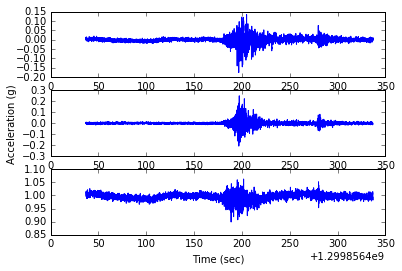

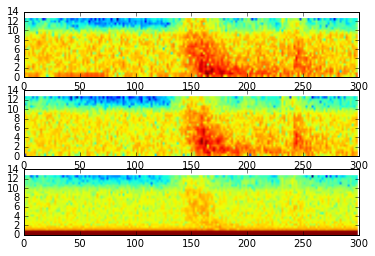

[ 158.22109604  158.38111758  158.42112279  241.15215373  241.5922122 ]


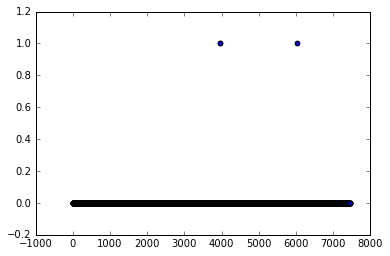

In [43]:
def PredictSeq(svc, t, x, y, z):
    '''
    Do prediction over the whole sequence
    '''
    chunk = 50
    
    signal = np.zeros(len(x) - 50)
    
    for head in range(0, len(x) - 50):
        tmp = range(head, head + chunk)
        tmp1 = numpy.concatenate((normalize(x[tmp]), normalize(y[tmp]), normalize(z[tmp])))
        signal[head] = svc.predict(tmp1.reshape(1, -1))
        #print(head, signal[head])
    plt.scatter(range(len(signal)), signal)
    return(signal)
t, x, y, z, label, filename, duration = Sampling( sim = True)
print(filename)
#print(len(t), len(x), len(y))
plot_data(t, x, y, z)
signal = PredictSeq(svc, t, x, y, z)
print(t[np.where(signal == 1)] - t[0])
#print(signal[duration - 30:duration])